## Update rule comparison of linear resistive networks

In [6]:
%reload_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
from spice_net import *
from helpers import *
import torch
from torch.autograd import Variable
from torch.nn.functional import mse_loss
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA
from analytic import *

In [7]:
# set Torch to use double arrays
torch.set_default_dtype(torch.double)

### Verify analytical solver gives correct results compared to SPICE baseline

In [8]:
MIN_SIZE = 5
MAX_SIZE = 40
N_TEST = 50
STRIDE = 7

in_nodes = 1
out_nodes = 1

num_pts = 40
lh = 2

for nodes in range(MIN_SIZE, MAX_SIZE+1, 7):
    for _ in range(N_TEST):
        edge_prob = np.random.uniform(0.5, 1)
        con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
        weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

        for i, (u, v) in enumerate(con_graph.edges()):
            con_graph[u][v]['type'] = 'resistor'
            con_graph[u][v]['weight'] = weights[i]

        node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
        node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
        node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

        out_plus = node_cfg[1][0][0]
        out_minus = node_cfg[1][0][1]

        net = LinearNetwork('test', con_graph, node_cfg)

        A = gen_A(net, net.inputs)
        r, M, constant_part = decomp_A(net, net.inputs)

        # Generate target inputs
        xs = np.linspace(-lh, lh, num_pts)[:, None]
        if in_nodes > 1:
            xs= np.hstack((xs, np.ones(xs.shape)))

        # Generate target outputs
        weights = np.abs(np.random.normal(0, 0.5, size=(in_nodes, 1)))
        ys = torch.Tensor(xs @ weights)

        # generate fixed test input matrix
        X = np.zeros((nodes + in_nodes - 1, num_pts))
        X[-in_nodes:] = xs.T
        X = torch.Tensor(X)

        downsampler = make_downsampler(net)

        pred_A = np.linalg.solve(A, X).squeeze()

        A_dc = (constant_part + torch.einsum('a...,a->...', M, r)).detach().numpy()
        assert np.allclose(A, np.array(A_dc))

        pred_dc = np.linalg.solve(A_dc, X).squeeze()

        pred_spice = net.predict(xs)

        # if needed, allow for additional room for floating-point error
        assert np.allclose(pred_A, pred_dc)
        assert np.allclose((downsampler @ pred_A).flatten(), pred_spice.flatten(), atol=1e-4)
        assert np.allclose((downsampler @ pred_dc).flatten(), pred_spice.flatten(), atol=1e-4)

print(f'Successfully validated {N_TEST * len(range(MIN_SIZE, MAX_SIZE+1, STRIDE))} test cases!')

Successfully validated 300 test cases!


### Set up Linear Network

In [9]:
# Fixed parameters
nodes = 8
edge_prob = 1.

in_nodes = 1
out_nodes = 1

In [10]:
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
weights = np.abs(np.random.normal(1, 0.5, size=con_graph.number_of_edges()))

for i, (u, v) in enumerate(con_graph.edges()):
    con_graph[u][v]['type'] = 'resistor'
    con_graph[u][v]['weight'] = weights[i]

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

out_plus = node_cfg[1][0][0]
out_minus = node_cfg[1][0][1]

net = LinearNetwork('test', con_graph, node_cfg)

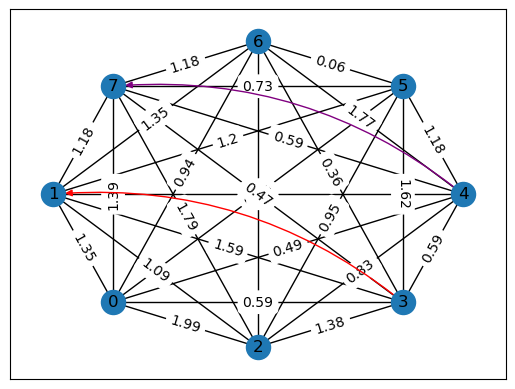

In [11]:
%matplotlib inline
visualize(net)

### Generate Data

In [12]:
# Generate the uniform inputs 
num_pts = 40
lh = 2

xs = np.linspace(-lh, lh, num_pts)[:, None]
xs_bias = np.hstack((xs, np.ones(xs.shape)))

In [13]:
# Generate target outputs
weights = np.abs(np.random.normal(0, 0.5, size=(2, 1)))
ys = torch.Tensor(xs_bias @ weights)

In [14]:
np.clip(weights, -1, 1)

array([[0.02939065],
       [0.60629148]])

In [15]:
# generate fixed test input matrix
# X = np.zeros((nodes + in_nodes - 1, num_pts))
# X[-in_nodes:] = xs_bias.T
X = torch.Tensor(xs.T)

### Set up contrastive and gradient update networks

In [16]:
# additional bookkeeping to keep track of which edges exist in our network
e1, e2 = [], []
for R in net.edges:
    a, b = list(map(int, R.node_names))
    e1.append(a)
    e2.append(b)

In [17]:
# initialize network and loss function
alpha = 0.01
lr = 3e2
penalty = False

# def make_loss_fn(analytic_net: Analytic_net, alpha):
#     def loss_fn(preds, ys, t):
#         return mse_loss(preds, ys) - alpha * torch.log(analytic_net.r).sum() / (t+5)
#     return loss_fn

analytic_net = Analytic_net(net, net.inputs)
# loss_fn = make_loss_fn(analytic_net, alpha)
downsampler = torch.Tensor(make_downsampler(net))

contrastive_net = Contrastive_net(net, 0.1, lr)

In [20]:
# train the network to reach an interesting point
iters = 1000
warmup = 100
optim = torch.optim.SGD([analytic_net.r], lr=lr)
losses = {'analytical':[], 'contrastive':[]}
physical_losses = {'analytical':[], 'contrastive':[]}
grads = {'analytical':[], 'contrastive':[]}
pts = {'analytical':[], 'contrastive':[]}
penalties = {'analytical':[], 'contrastive':[]}

for t in range(iters):
    for x, y in np.random.shuffle(list(zip(X, ys))):
        pts['analytical'].append(analytic_net.r.detach().numpy().copy())
        pts['contrastive'].append(contrastive_net.free_net.r.detach().numpy().copy())

        preds_a = downsampler @ analytic_net(x)
        preds_c = downsampler @ contrastive_net(x)

        # gradient-based update
        physical_loss_a = mse_loss(preds_a,  y)
        pen_a = -alpha * torch.log(analytic_net.r).sum() / (t+1)

        loss_a = physical_loss_a 
        if penalty:
            loss_a += pen_a

        optim.zero_grad()
        loss_a.backward()
        optim.step()

        # contrastive update
        physical_loss_c = mse_loss(preds_c, y)
        update = contrastive_net.contrastive_update(y)

        # log data
        grad_a = analytic_net.r.grad

        penalties['analytical'].append(pen_a.detach())
        grads['analytical'].append(grad_a.detach().numpy().copy())
        losses['analytical'].append(loss_a.detach())
        physical_losses['analytical'].append(physical_loss_a.detach())

        losses['contrastive'] = physical_loss_c.detach().numpy()
        grads['contrastive'] = update.detach().numpy().copy()

RuntimeError: The size of tensor a (40) must match the size of tensor b (64) at non-singleton dimension 1

### Compare the 2 update rules